# A Simulation Study for Time-varying coefficients

In [1]:
import math
from math import pi
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist

from orbit.estimators.pyro_estimator import PyroEstimatorVI
from orbit.estimators.stan_estimator import StanEstimatorMAP
from orbit.diagnostics.metrics import smape
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

%load_ext autoreload
%autoreload 2

# Data Simulation Modules

In [2]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*pi*tau),
        'beta3': 1.01 + np.sin(4*pi*(tau-1/8)),
#         'x1': stats.chi2.rvs(4, size=n),
#         'x2': stats.t.rvs(2, size=n),
#         'x3': stats.t.rvs(2, size=n),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
    
    # add error to the data 
    #err_cov = np.exp(-cdist(data.tau.values.reshape(n, -1), data.tau.values.reshape(n, -1), 'euclid')/10)
    #L = np.linalg.cholesky(err_cov).T
    #data['error2'] = L.dot(stats.chi2.rvs(100, size=n))
    
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    #data['y2'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error2
    #data['y3'] = data.trend + data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

def sim_data_rw(n, RS, p=3):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

In [3]:
seas_data = sim_data_seasonal(n=1000, RS=8888)
seas_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.001,2018-01-01,0.002,1.016283,0.010079,-4.112205,6.235252,8.318071,1.000000,-0.772024,5.640371
1,0.002,2018-01-02,0.004,1.022566,0.010316,-0.499279,-14.816010,3.641032,1.075149,1.243571,-13.871215
2,0.003,2018-01-03,0.006,1.028848,0.010711,1.826034,-2.897783,-17.144133,1.278494,-0.352154,-3.506200
3,0.004,2018-01-04,0.008,1.035130,0.011263,24.874740,5.439502,6.055187,1.104741,-0.571943,5.325848
4,0.005,2018-01-05,0.010,1.041411,0.011973,1.734577,-16.383980,9.075009,1.059079,-0.218024,-17.154473
5,0.006,2018-01-06,0.012,1.047690,0.012841,-11.059695,12.494699,2.577940,1.088198,0.541397,13.532358
6,0.007,2018-01-07,0.014,1.053968,0.013866,-6.065916,4.606459,-9.182241,1.153368,0.474600,5.117413
7,0.008,2018-01-08,0.016,1.060244,0.015049,0.945238,3.450288,13.376691,1.244678,2.122431,5.997009
8,0.009,2018-01-09,0.018,1.066519,0.016389,11.628231,11.262647,16.722551,1.167512,0.439053,12.934243
9,0.010,2018-01-10,0.020,1.072791,0.017885,2.740874,2.271040,-17.405263,1.352738,0.496264,2.676133


In [4]:
rw_data = sim_data_rw(n=300, RS=8888, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,1.118687,12.579436,-18.705481,0.083833,0.118039,0.106882,4.238243,2018-01-01
1,0.251493,5.300673,8.974563,0.081579,0.116649,0.116075,6.762299,2018-01-02
2,-12.535904,2.134341,4.224095,0.083838,0.112736,0.121694,4.576347,2018-01-03
3,-6.830381,3.094571,-1.926185,0.067788,0.111347,0.126284,4.497561,2018-01-04
4,-3.370150,3.899625,-3.083105,0.086333,0.099882,0.138985,5.230371,2018-01-05
5,-3.364463,-4.186151,13.149254,0.076195,0.108590,0.142555,6.102766,2018-01-06
6,-3.663559,-14.795409,-1.731279,0.091534,0.099006,0.156208,3.284992,2018-01-07
7,7.205991,-5.623366,-11.806551,0.100954,0.099507,0.160083,2.529016,2018-01-08
8,-3.643661,3.799626,-1.398166,0.100640,0.087954,0.163894,4.908982,2018-01-09
9,9.222329,1.695171,-0.896493,0.098496,0.085971,0.172410,5.529784,2018-01-10


## Test on how knots and segements interact

In [5]:
from orbit.utils.knots import get_knot_idx_by_dist, get_knot_idx, get_knot_dates

In [6]:
knot_idx = get_knot_idx(num_of_obs=400, num_of_segments=10)
knot_idx

array([  0,  39,  79, 119, 159, 199, 239, 279, 319, 359, 399])

In [7]:
knot_idx = get_knot_idx(num_of_obs=250, knot_distance=10)
knot_idx

array([  0,   9,  19,  29,  39,  49,  59,  69,  79,  89,  99, 109, 119,
       129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249])

In [8]:
date_array = rw_data['date'].values
date_array.dtype

dtype('<M8[ns]')

In [9]:
date_array[:5]

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [10]:
knot_dates=['2018-01-01','2018-07-01','2018-09-09']
knot_dates = np.array(knot_dates, dtype='datetime64')
knot_dates[:5]

array(['2018-01-01', '2018-07-01', '2018-09-09'], dtype='datetime64[D]')

In [11]:
knot_idx = get_knot_idx(date_array=date_array, knot_dates=knot_dates)
knot_idx

array([  0, 181, 251])

In [12]:
infer_freq = pd.infer_freq(date_array)

In [13]:
knot_idx * np.timedelta64(1, infer_freq)  + date_array[0]

array(['2018-01-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-09-09T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
get_knot_dates(date_array[0], knot_idx, infer_freq)

array(['2018-01-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-09-09T00:00:00.000000000'], dtype='datetime64[ns]')

# Random Walk Coefficients Simulation Study

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [15]:
from orbit.models import KTR

In [16]:
p = 3
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]

In [17]:
ktrx_neutral = KTR(
    response_col='y',
    date_col='date',
    level_knot_scale=0.1,
    
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,

    flat_multiplier=True,
)

INFO:root:Using 501 steps, 1000 samples, 0.2 learning rate and 100 particles for SVI.


In [18]:
ktrx_neutral.fit(df=rw_data)  

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 1530.3, scale = 0.10223
step   50 loss = 353.14, scale = 0.053381
step  100 loss = 341.11, scale = 0.054994
step  150 loss = 322.2, scale = 0.052265
step  200 loss = 311.67, scale = 0.052946
step  250 loss = 306.05, scale = 0.05286
step  300 loss = 303.59, scale = 0.052459
step  350 loss = 301.37, scale = 0.051735
step  400 loss = 300.76, scale = 0.052673
step  450 loss = 300.87, scale = 0.052548
step  500 loss = 300.74, scale = 0.052597


In [19]:
idx = 3

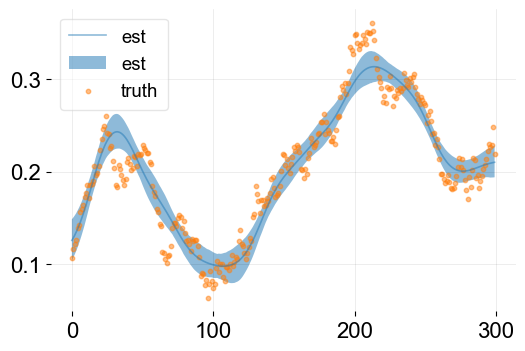

In [20]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True)
x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

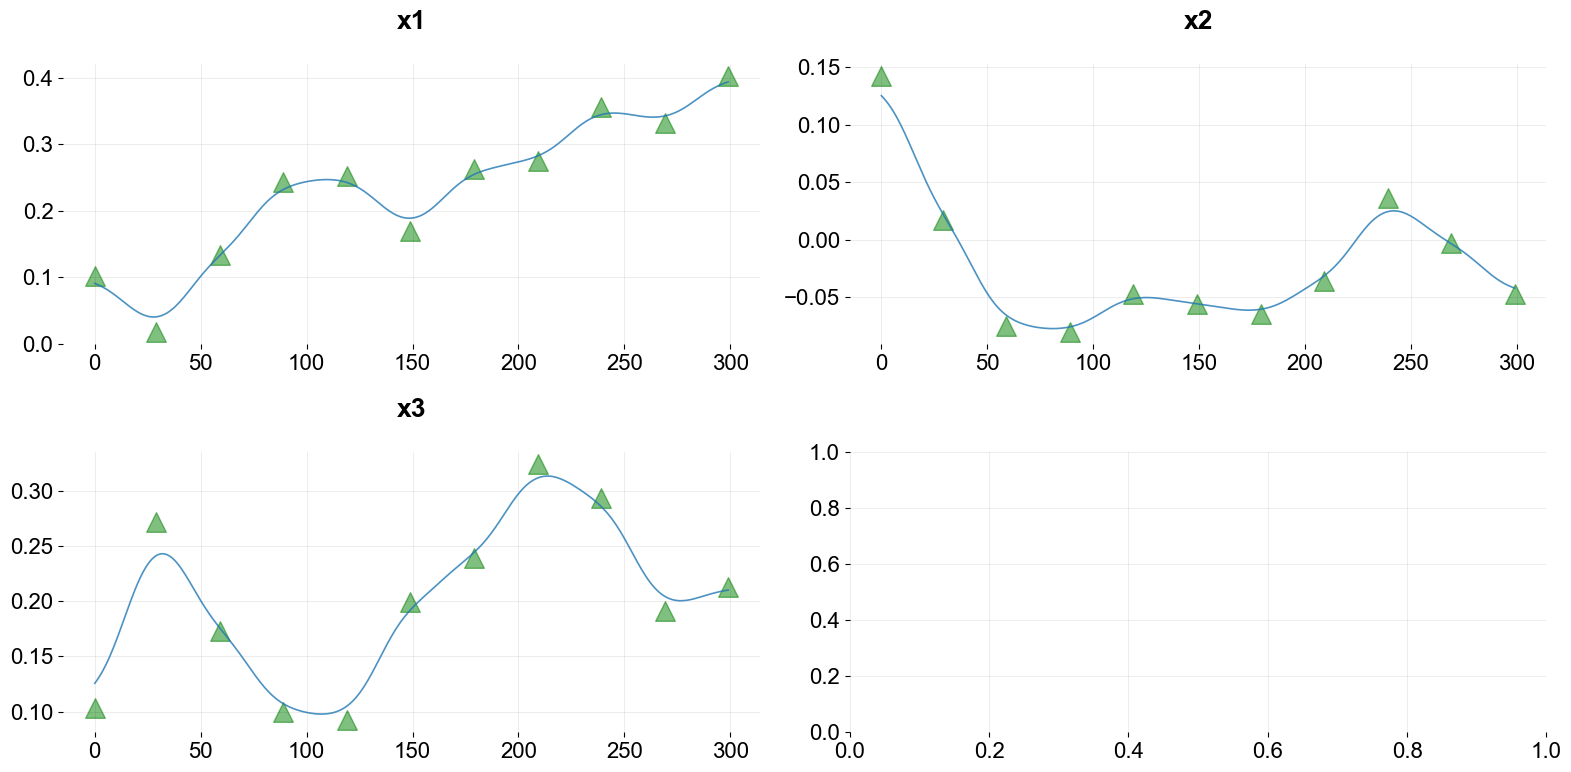

In [21]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [22]:
ktrx_pos = KTR(
    response_col='y',
    date_col='date',

    level_knot_scale=0.1,
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),
    # this is the only change fromp previous setting
    regressor_sign=['+'] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,

    flat_multiplier=True,
)

INFO:root:Using 501 steps, 1000 samples, 0.2 learning rate and 100 particles for SVI.


In [23]:
ktrx_pos.fit(df=rw_data) 

INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 2305.2, scale = 0.10699
step   50 loss = 441.04, scale = 0.28282
step  100 loss = 403.93, scale = 0.44586
step  150 loss = 401.88, scale = 0.47063
step  200 loss = 402.26, scale = 0.45344
step  250 loss = 401.5, scale = 0.46129
step  300 loss = 401.04, scale = 0.46727
step  350 loss = 401.11, scale = 0.46234
step  400 loss = 401, scale = 0.45844
step  450 loss = 401.02, scale = 0.46248
step  500 loss = 400.94, scale = 0.45978


In [24]:
idx = 3

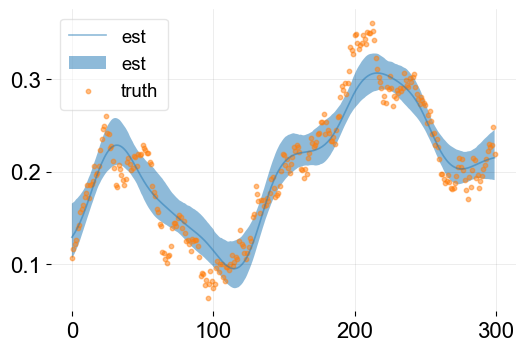

In [25]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True)

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=10, alpha=0.5)
plt.legend();

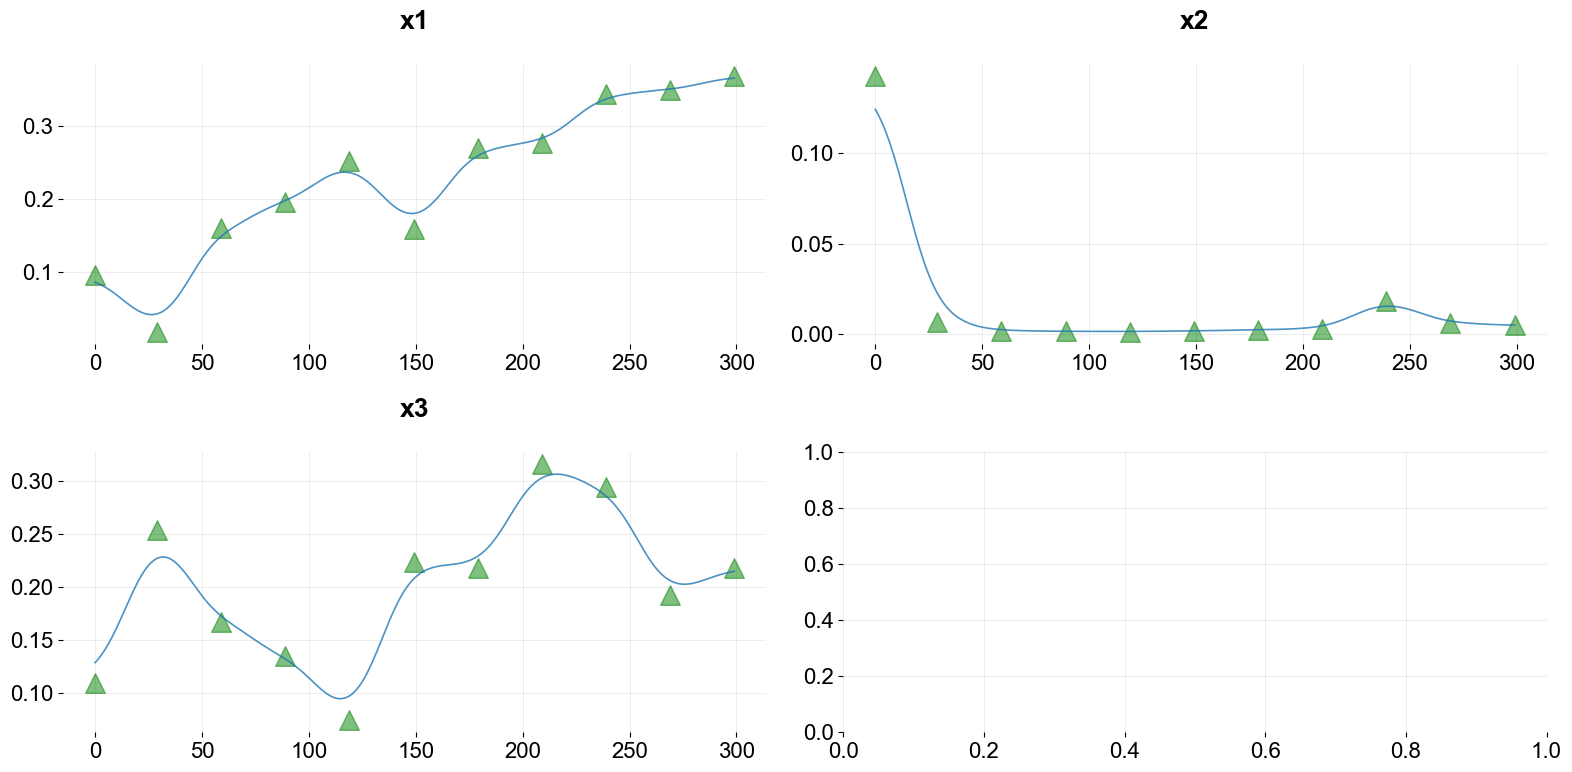

In [26]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

# Sine - Cosine Coefficients Simulation Study

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [27]:
p = 3
# define independent and response variables
regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]

In [28]:
%%time
ktrx_neutral = KTR(
    response_col='y',
    date_col='date',
    level_knot_scale=.1,

    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[10.0] * len(regressor_col),
    regressor_knot_scale=[2.0] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,
 
    flat_multiplier=True,
)

ktrx_neutral.fit(df=seas_data)                                  

INFO:root:Using 501 steps, 1000 samples, 0.2 learning rate and 100 particles for SVI.
INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 9428, scale = 0.12439
step   50 loss = 4039.9, scale = 0.30986
step  100 loss = 4078, scale = 0.43249
step  150 loss = 3773.9, scale = 0.39285
step  200 loss = 3433.2, scale = 0.3148
step  250 loss = 2077.2, scale = 0.16773
step  300 loss = 1787.3, scale = 0.15371
step  350 loss = 1786.4, scale = 0.1519
step  400 loss = 1785.1, scale = 0.15628
step  450 loss = 1785.2, scale = 0.15517
step  500 loss = 1785.1, scale = 0.15593
CPU times: user 15.8 s, sys: 2.91 s, total: 18.7 s
Wall time: 11.3 s


In [29]:
idx = 3

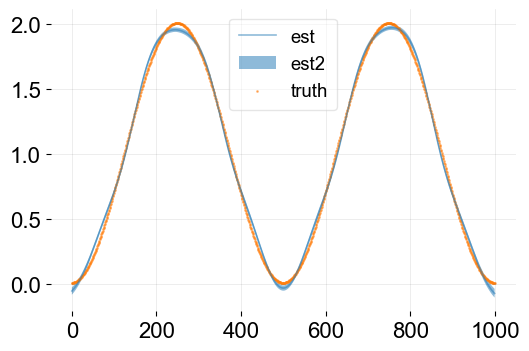

In [30]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True)

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est2', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=1, alpha=0.5)
plt.legend();

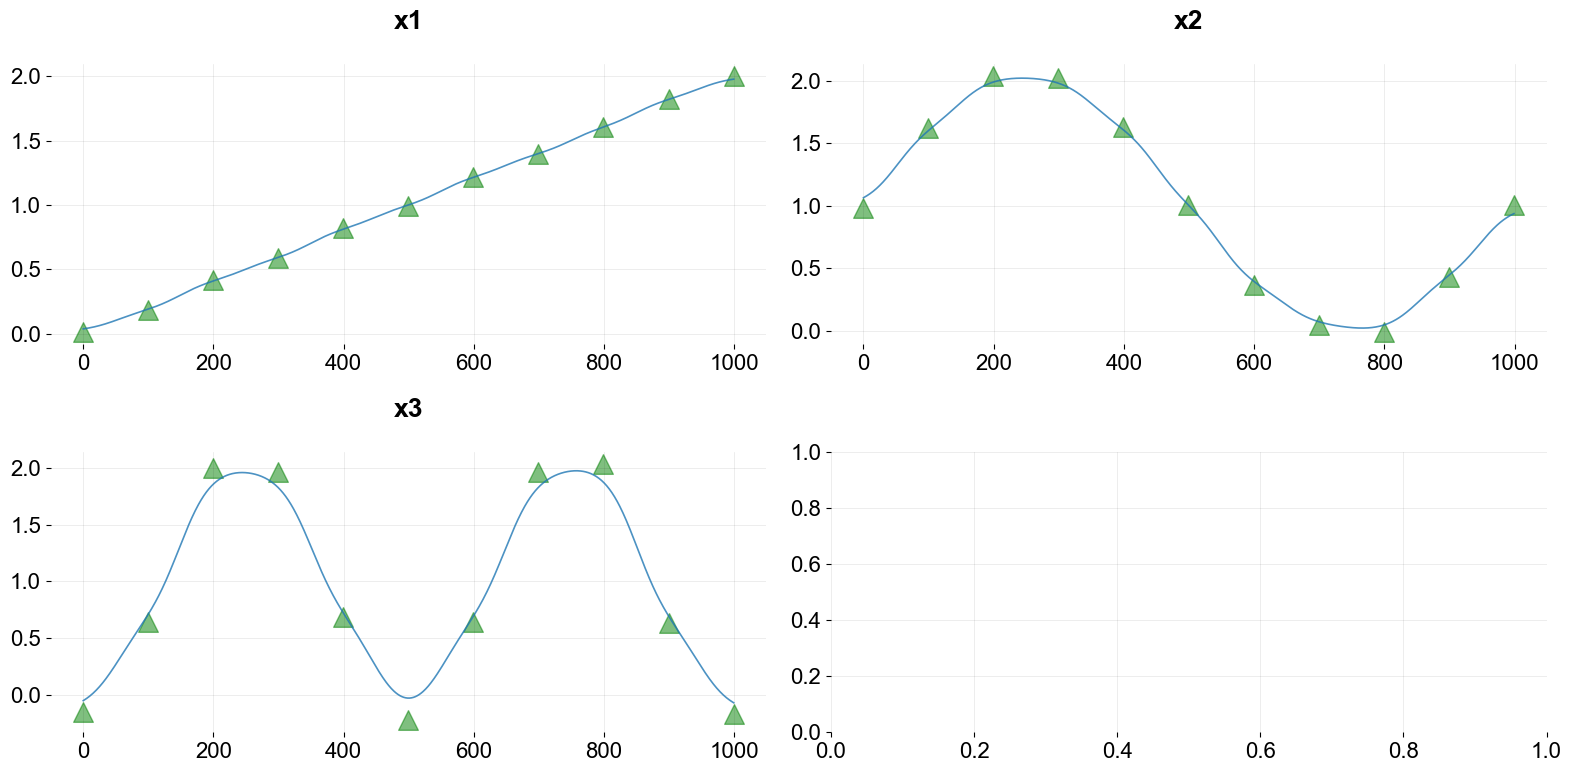

In [31]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [32]:
%%time
ktrx_pos = KTR(
    response_col='y',
    date_col='date',
    level_knot_scale=.1,

    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[10.0] * len(regressor_col),
    regressor_knot_scale=[2.0] * len(regressor_col),
    # this is the only change fromp previous setting
    regressor_sign=['+'] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,
 
    flat_multiplier=True,
)

ktrx_pos.fit(df=seas_data)                                  

INFO:root:Using 501 steps, 1000 samples, 0.2 learning rate and 100 particles for SVI.
INFO:root:Guessed max_plate_nesting = 1


step    0 loss = 14607, scale = 0.089832
step   50 loss = 2412.2, scale = 0.25205
step  100 loss = 1898.9, scale = 0.33786
step  150 loss = 1887.2, scale = 0.32232
step  200 loss = 1887.3, scale = 0.32843
step  250 loss = 1877.8, scale = 0.32869
step  300 loss = 1875.5, scale = 0.33468
step  350 loss = 1874.9, scale = 0.3348
step  400 loss = 1874.4, scale = 0.33362
step  450 loss = 1875.3, scale = 0.32995
step  500 loss = 1874.1, scale = 0.33238
CPU times: user 15.9 s, sys: 3.3 s, total: 19.2 s
Wall time: 12.2 s


In [33]:
idx = 3

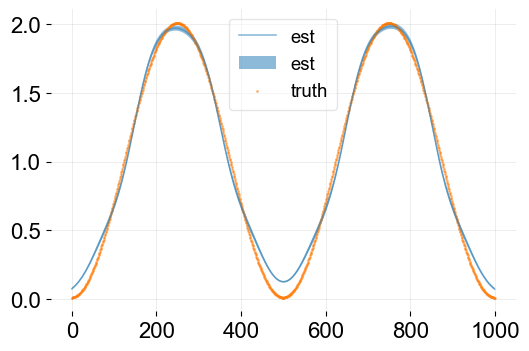

In [34]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True)

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.5)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=1, alpha=0.5)
plt.legend();

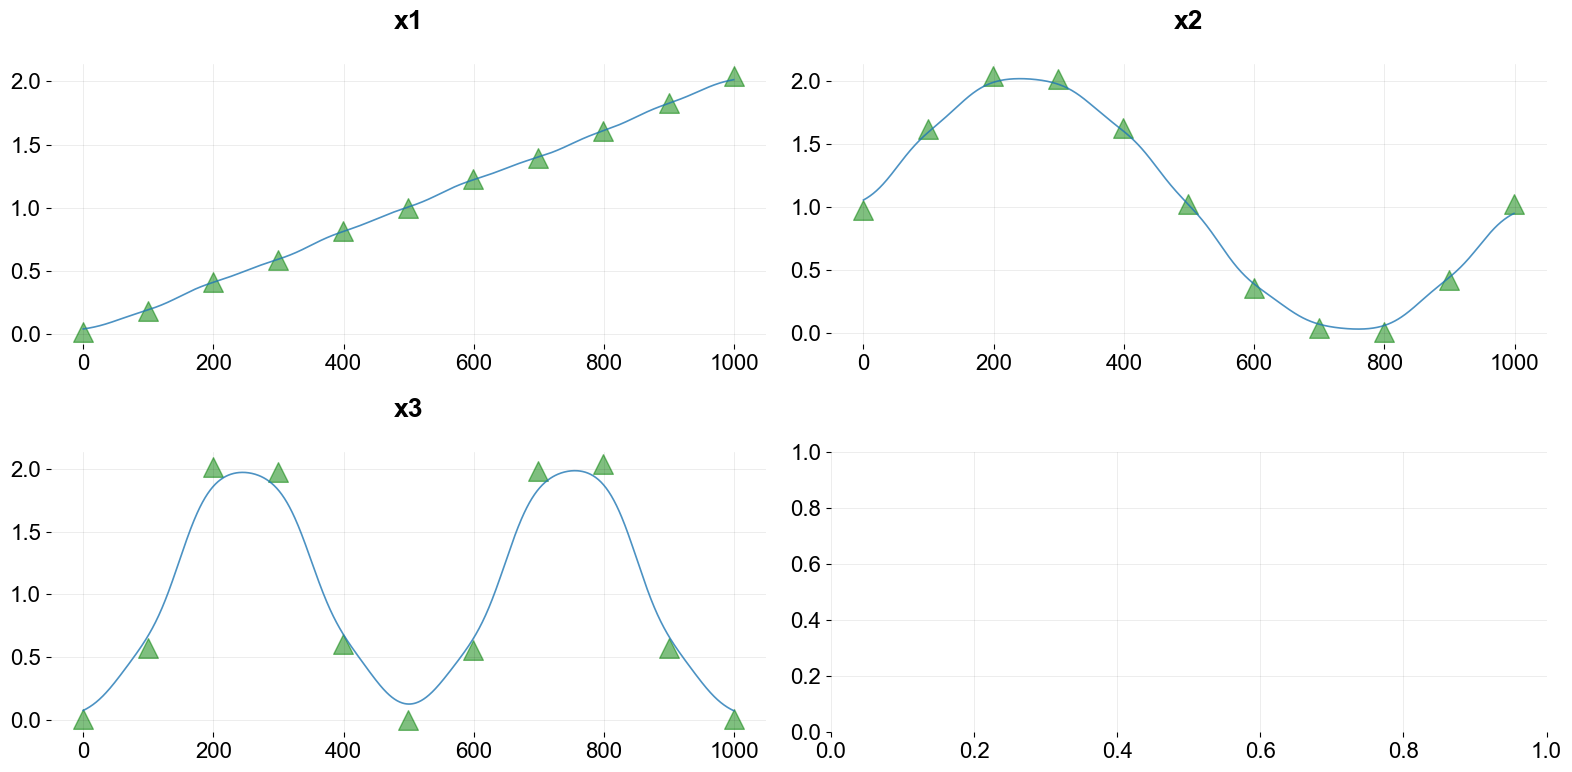

In [35]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))